<img src="https://full-stack-assets.s3.eu-west-3.amazonaws.com/M08-deep-learning/AT%26T_logo_2016.svg" alt="AT&T LOGO" width="50%" />

# Orange SPAM detector

## Company's Description 📇

AT&T Inc. is an American multinational telecommunications holding company headquartered at Whitacre Tower in Downtown Dallas, Texas. It is the world's largest telecommunications company by revenue and the third largest provider of mobile telephone services in the U.S. As of 2022, AT&T was ranked 13th on the Fortune 500 rankings of the largest United States corporations, with revenues of $168.8 billion! 😮

## Project 🚧

One of the main pain point that AT&T users are facing is constant exposure to SPAM messages.

AT&T has been able to manually flag spam messages for a time, but they are looking for an automated way of detecting spams to protect their users.

## Goals 🎯

Your goal is to build a spam detector, that can automatically flag spams as they come based sollely on the sms' content.

## Scope of this project 🖼️

To start off, AT&T would like you to use the folowing dataset:

[Dowload the Dataset](https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv)

## Helpers 🦮

To help you achieve this project, here are a few tips that should help you:

### Start simple
A good deep learing model does not necessarily have to be super complicated!

### Transfer learning
You do not have access to a whole lot of data, perhaps channeling the power of a more sophisticated model trained on billions of observations might help!

## Deliverable 📬

To complete this project, your team should:

* Write a notebook that runs preprocessing and trains one or more deep learning models in order to predict the spam or ham nature of the sms
* State the achieved performance clearly

In [1]:
# Import Tensorflow & Pathlib librairies
import tensorflow as tf
import pathlib
import pandas as pd
import os
import io
import warnings
import joblib
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

import string
import nltk
from nltk.corpus import stopwords

from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
dataset = pd.read_csv("https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv", encoding = "ISO-8859-1")
dataset.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
dataset.describe(include='all')

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


Remove the unnecessary columns for dataset and rename the column names.

In [4]:
att = dataset.loc[:,['v1','v2']]
att.columns = ["label", "message"]
att

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [5]:
att['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64



    There is two unique labels.
    There are some repeated messages as unique is less that the count due to some comman messages.



Let's use groupby to use describe by label, this way we can begin to think about the features that separate ham and spam!

In [6]:
att.groupby('label').describe().T

label                              ham  \
message count                     4825   
        unique                    4516   
        top     Sorry, I'll call later   
        freq                        30   

label                                                        spam  
message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4



    4825 ham messages out of which 4516 are unique..
    747 span messages out of which 653 are unique.
    "Sorry, I'll call later" is the most popular ham message with repetition of 30 times.
    "Please call our customer service representativ..." is the most popular spam message with repetition 4 times.



In [7]:
att['length'] = att['message'].apply(len)
att.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [8]:
# Count the frequency of top 10 messages.
att['message'].value_counts().rename_axis(['message']).reset_index(name='counts').head(10)

,message,counts
0,"Sorry, I'll call later",30
1,I cant pick the phone right now. Pls send a me...,12
2,Ok...,10
3,7 wonders in My WORLD 7th You 6th Ur style 5th...,4
4,"Say this slowly.? GOD,I LOVE YOU &amp; I NEED ...",4
5,Your opinion about me? 1. Over 2. Jada 3. Kusr...,4
6,Ok.,4
7,"Wen ur lovable bcums angry wid u, dnt take it ...",4
8,Okie,4
9,Ok,4



It seems people are really busy. "Sorry, i'll call later" tops the message list with 30 counts with "I cant pick the phone right now. Pls send a message" comes second with 12 counts.

There is a quite lot of Ok...Okie. in there too.



## Data Visualization

Let's visualize this!


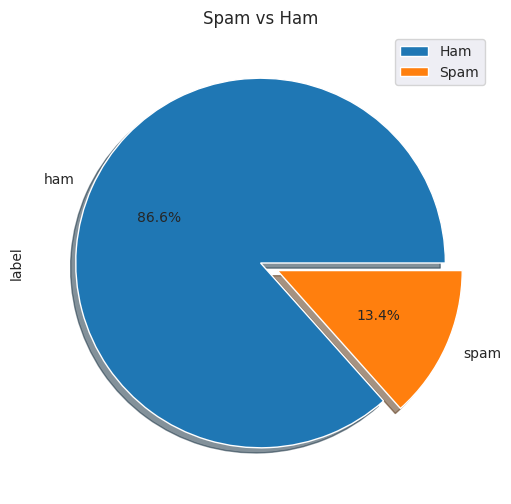

In [9]:
att["label"].value_counts().plot(kind = 'pie',explode=[0, 0.1],figsize=(6, 6),autopct='%1.1f%%',shadow=True)
plt.title("Spam vs Ham")
plt.legend(["Ham", "Spam"])
plt.show()



A lot of messages are actually not spam. About 86% of our dataset consists of normal messages.


Text(0, 0.5, 'Frequency')

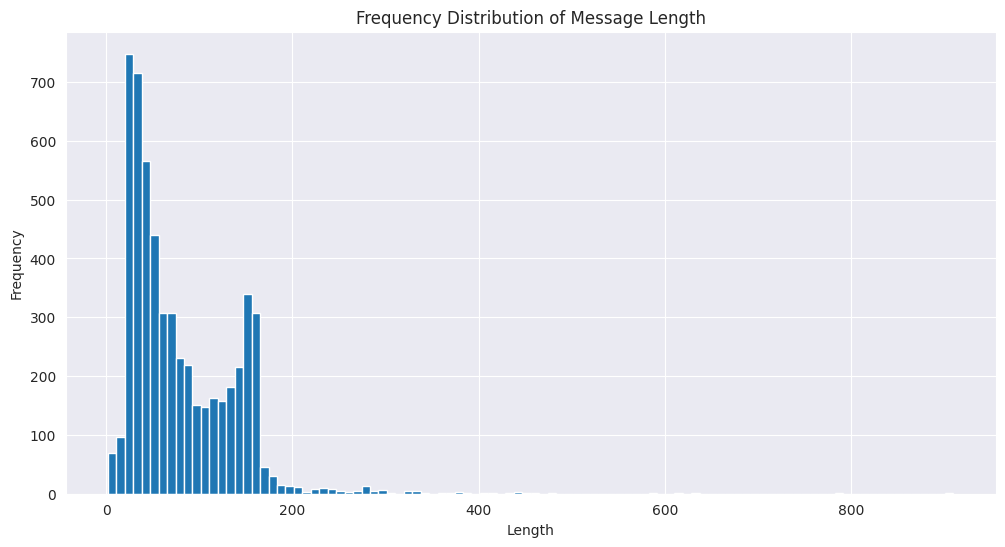

In [10]:
plt.figure(figsize=(12,6))
att['length'].plot(bins=100, kind='hist') # with 100 length bins (100 length intervals)
plt.title("Frequency Distribution of Message Length")
plt.xlabel("Length")
plt.ylabel("Frequency")



Most of the message lenght is less than 200. Note that x-axis goes all the way to 1000ish, this must mean that there is some really long message!


In [11]:
att['length'].describe()

count    5572.000000
mean       80.118808
std        59.690841
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: length, dtype: float64

Woah! 910 characters, let's use masking to find this message:

In [12]:
att[att['length'] == 910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

Looks like we have some sort of Romeo sending texts! But let's focus back on the idea of trying to see if message length is a distinguishing feature between ham and spam:

array([<Axes: title={'center': 'ham'}>, <Axes: title={'center': 'spam'}>],
      dtype=object)

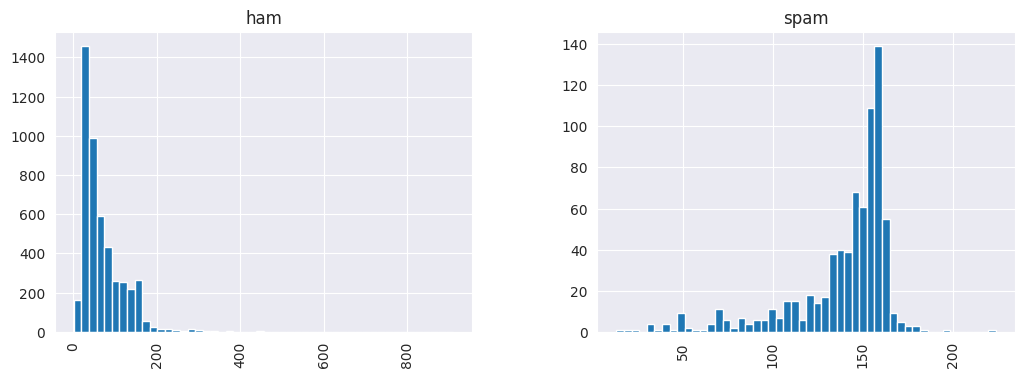

In [13]:
att.hist(column='length', by='label', bins=50,figsize=(12,4))



Looks like spam messages are usually longer. Maybe message length can become a feature to predict whether the message is spam/ ham ?

Now let's begin to process the data so we can eventually use it with SciKit Learn!


## Text Pre-processing

In [14]:
!python -m spacy download en_core_web_md -q

2023-07-07 08:58:15.058061: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 16.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [15]:
# Import Spacy and french initialisation
import en_core_web_md
# Import Stop words
from spacy.lang.en.stop_words import STOP_WORDS

nlp = en_core_web_md.load()


# Remove all non alphanumeric characters except whitespaces
att["message_clean"] = att["message"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" " or ch=="'"))
# remove double spaces and spaces at the beginning and end of strings
att["message_clean"] = att["message_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
# remove stop words and replace everyword with their lemma
att["message_clean"] = att["message_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))

att

,label,message,length,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",111,jurong point crazy available bugis n great wor...
1,ham,Ok lar... Joking wif u oni...,29,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,49,u dun early hor u c
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,nah think usf live
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,161,2nd time try 2 contact u u win å750 pound priz...
5568,ham,Will Ì_ b going to esplanade fr home?,37,ì b esplanade fr home
5569,ham,"Pity, * was in mood for that. So...any other s...",57,pity mood soany suggestion
5570,ham,The guy did some bitching but I acted like i'd...,125,guy bitching act like interested buy week free


Lets study individual spam/ham messages

In [16]:
spam_messages = att[att["label"] == "spam"]["message"]
ham_messages = att[att["label"] == "ham"]["message"]
print("No of spam messages : ",len(spam_messages))
print("No of ham messages : ",len(ham_messages))

No of spam messages :  747
No of ham messages :  4825


Wordcloud for Spam Messages

In [17]:
def text_preprocess(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    nopunc = nopunc.lower()

    # Now just remove any stopwords and non alphabets
    nostop=[word for word in nopunc.split() if word.isalpha()]

    return nostop

In [18]:
# This may take a while....
spam_words = text_preprocess(spam_messages)

In [19]:
# lets print some spam words
spam_words[:10]

['free', 'entry', 'in', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup']

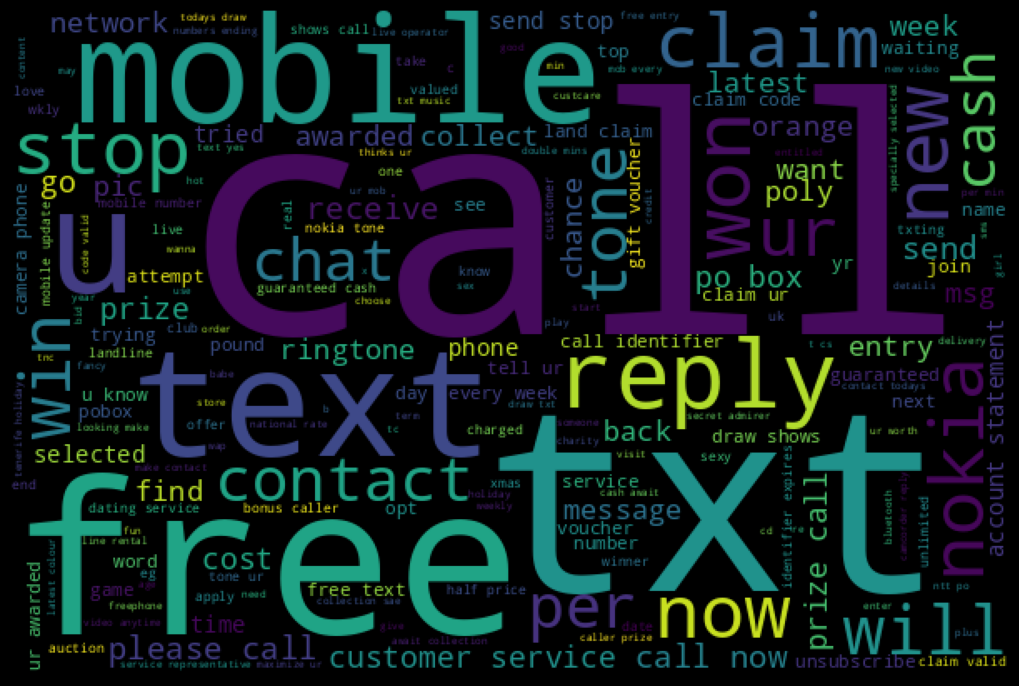

In [20]:
spam_wordcloud = WordCloud(width=600, height=400).generate(' '.join(spam_words))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Wordcloud for spam messages shows that words like call, txt, win, free, reply, mobile, text etc. are widely used, let's check them statistically.

In [21]:
print("Top 10 Spam words are :\n")
print(pd.Series(spam_words).value_counts().head(10))

Top 10 Spam words are :

to      681
a       370
call    331
your    251
the     202
you     196
for     193
or      188
is      152
free    146
dtype: int64


Wordcloud for Ham Messages

In [22]:
# This may take a while...
ham_words = text_preprocess(ham_messages)

In [23]:
# lets pring some ham words
ham_words[:10]

['go',
 'until',
 'jurong',
 'available',
 'only',
 'in',
 'bugis',
 'n',
 'great',
 'world']

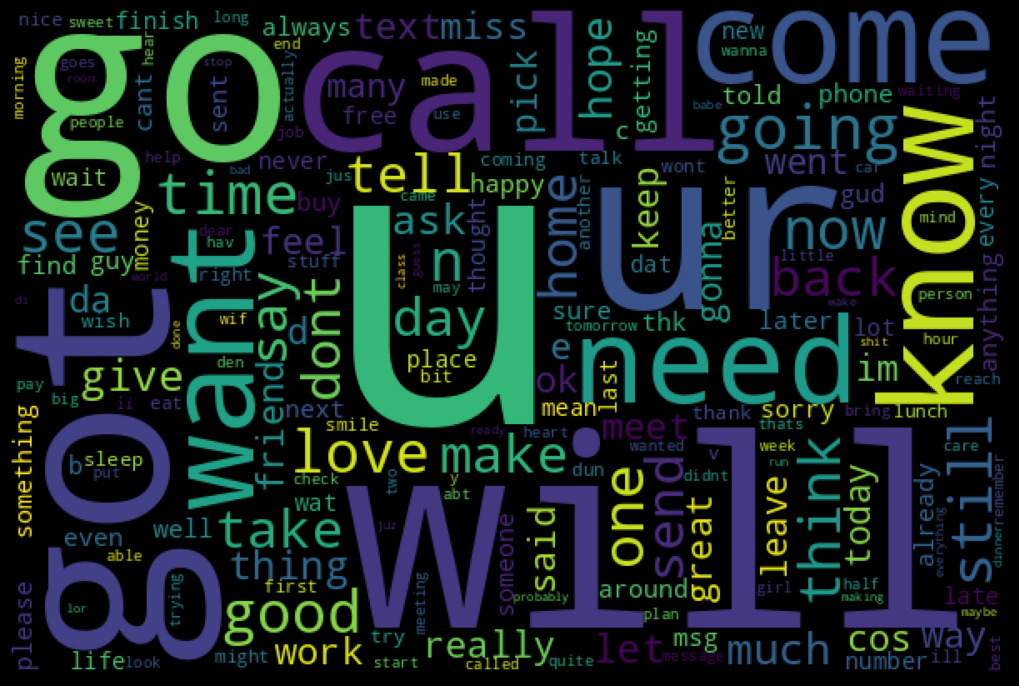

In [24]:
ham_wordcloud = WordCloud(width=600, height=400).generate(' '.join(ham_words))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Wordcloud for ham messages shows that words like got, come, go, ur, know, call etc. are widely used, let's check them statistically.

In [25]:
print("Top 10 Ham words are :\n")
print(pd.Series(ham_words).value_counts().head(10))

Top 10 Ham words are :

i      1783
you    1569
to     1539
the    1080
a      1031
and     822
u       820
in      770
my      702
is      684
dtype: int64


Using tf.keras.preprocessing.text.Tokenizer Tokenizer, process to encoding all the reviews (be careful, some reviews might have been entirely erased, try and understand why, remove those reviews)

In [26]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token="out_of_vocab") # instanciate the tokenizer
# num_words indicates the number of words to keep in the tokenization num_words=1000
# oov_token if given, it will be added to word_index and used to replace out-of-vocabulary words during text_to_sequence calls
tokenizer.fit_on_texts(att.message_clean)# fit the tokenizer on the texts
# in this step the tokenizer will list all unique tokens in the text
# and associate them with a specific integer.

# This step will effectively transform the texts into sequences of indices
att["message_encoded"] = tokenizer.texts_to_sequences(att.message_clean)

att.head()

,label,message,length,message_clean,message_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",111,jurong point crazy available bugis n great wor...,"[3603, 232, 447, 463, 940, 32, 50, 206, 941, 7..."
1,ham,Ok lar... Joking wif u oni...,29,ok lar joke wif u oni,"[8, 195, 464, 290, 2, 1460]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry 2 wkly comp win fa cup final tkts 2...,"[10, 303, 3, 529, 658, 30, 1461, 843, 424, 146..."
3,ham,U dun say so early hor... U c already then say...,49,u dun early hor u c,"[2, 125, 149, 2365, 2, 79]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,nah think usf live,"[703, 20, 659, 130]"


In [27]:
att["len_message_encoded"] = att["message_encoded"].apply(lambda x : len(x))
att

,label,message,length,message_clean,message_encoded,len_message_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",111,jurong point crazy available bugis n great wor...,"[3603, 232, 447, 463, 940, 32, 50, 206, 941, 7...",14
1,ham,Ok lar... Joking wif u oni...,29,ok lar joke wif u oni,"[8, 195, 464, 290, 2, 1460]",6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry 2 wkly comp win fa cup final tkts 2...,"[10, 303, 3, 529, 658, 30, 1461, 843, 424, 146...",22
3,ham,U dun say so early hor... U c already then say...,49,u dun early hor u c,"[2, 125, 149, 2365, 2, 79]",6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,nah think usf live,"[703, 20, 659, 130]",4
...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,161,2nd time try 2 contact u u win å750 pound priz...,"[268, 16, 51, 3, 92, 2, 2, 30, 8196, 282, 68, ...",19
5568,ham,Will Ì_ b going to esplanade fr home?,37,ì b esplanade fr home,"[43, 109, 1543, 574, 23]",5
5569,ham,"Pity, * was in mood for that. So...any other s...",57,pity mood soany suggestion,"[8199, 935, 8200, 3599]",4
5570,ham,The guy did some bitching but I acted like i'd...,125,guy bitching act like interested buy week free,"[113, 8201, 1603, 13, 1119, 86, 35, 10]",8


In [28]:
att = att[att["len_message_encoded"] > 0]
att

,label,message,length,message_clean,message_encoded,len_message_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",111,jurong point crazy available bugis n great wor...,"[3603, 232, 447, 463, 940, 32, 50, 206, 941, 7...",14
1,ham,Ok lar... Joking wif u oni...,29,ok lar joke wif u oni,"[8, 195, 464, 290, 2, 1460]",6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry 2 wkly comp win fa cup final tkts 2...,"[10, 303, 3, 529, 658, 30, 1461, 843, 424, 146...",22
3,ham,U dun say so early hor... U c already then say...,49,u dun early hor u c,"[2, 125, 149, 2365, 2, 79]",6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,nah think usf live,"[703, 20, 659, 130]",4
...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,161,2nd time try 2 contact u u win å750 pound priz...,"[268, 16, 51, 3, 92, 2, 2, 30, 8196, 282, 68, ...",19
5568,ham,Will Ì_ b going to esplanade fr home?,37,ì b esplanade fr home,"[43, 109, 1543, 574, 23]",5
5569,ham,"Pity, * was in mood for that. So...any other s...",57,pity mood soany suggestion,"[8199, 935, 8200, 3599]",4
5570,ham,The guy did some bitching but I acted like i'd...,125,guy bitching act like interested buy week free,"[113, 8201, 1603, 13, 1119, 86, 35, 10]",8


In [29]:
message_pad = tf.keras.preprocessing.sequence.pad_sequences(att.message_encoded, padding="post")

In [30]:
message_pad

array([[3603,  232,  447, ...,    0,    0,    0],
       [   8,  195,  464, ...,    0,    0,    0],
       [  10,  303,    3, ...,    0,    0,    0],
       ...,
       [8199,  935, 8200, ...,    0,    0,    0],
       [ 113, 8201, 1603, ...,    0,    0,    0],
       [2080,  322,    0, ...,    0,    0,    0]], dtype=int32)

In [31]:
message_pad.shape

(5554, 74)

In [32]:
att['label_num'] = att['label'].apply(lambda x: 0 if x == 'ham' else 1)
att

,label,message,length,message_clean,message_encoded,len_message_encoded,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",111,jurong point crazy available bugis n great wor...,"[3603, 232, 447, 463, 940, 32, 50, 206, 941, 7...",14,0
1,ham,Ok lar... Joking wif u oni...,29,ok lar joke wif u oni,"[8, 195, 464, 290, 2, 1460]",6,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry 2 wkly comp win fa cup final tkts 2...,"[10, 303, 3, 529, 658, 30, 1461, 843, 424, 146...",22,1
3,ham,U dun say so early hor... U c already then say...,49,u dun early hor u c,"[2, 125, 149, 2365, 2, 79]",6,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,nah think usf live,"[703, 20, 659, 130]",4,0
...,...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,161,2nd time try 2 contact u u win å750 pound priz...,"[268, 16, 51, 3, 92, 2, 2, 30, 8196, 282, 68, ...",19,1
5568,ham,Will Ì_ b going to esplanade fr home?,37,ì b esplanade fr home,"[43, 109, 1543, 574, 23]",5,0
5569,ham,"Pity, * was in mood for that. So...any other s...",57,pity mood soany suggestion,"[8199, 935, 8200, 3599]",4,0
5570,ham,The guy did some bitching but I acted like i'd...,125,guy bitching act like interested buy week free,"[113, 8201, 1603, 13, 1119, 86, 35, 10]",8,0


In [33]:
att.label_num.shape

(5554,)

In [34]:
message_pad.shape

(5554, 74)

In [35]:
full_ds = tf.data.Dataset.from_tensor_slices((message_pad, att.label_num.values))

In [36]:
full_ds

<_TensorSliceDataset element_spec=(TensorSpec(shape=(74,), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [37]:
message_pad.shape[0]

5554

Do a train_test_split of your data (keep about 70% in the train). For this you may use sklearn.model_selection.train_test_split.

In [38]:
# Train Test Split
xtrain, xval, ytrain, yval = train_test_split(message_pad, att.label_num, test_size = 0.3, stratify=att.label_num)

In [39]:
xtrain

array([[  51,   92,   25, ...,    0,    0,    0],
       [1631, 4372,    0, ...,    0,    0,    0],
       [4101,  137,   21, ...,    0,    0,    0],
       ...,
       [5256, 1121, 5257, ...,    0,    0,    0],
       [  54,   67, 5254, ...,    0,    0,    0],
       [  31,  490, 1249, ...,    0,    0,    0]], dtype=int32)

In [40]:
train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val = tf.data.Dataset.from_tensor_slices((xval,yval))

In [41]:
# We then organize the dataste per batch
train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

In [42]:
next(iter(train_batch.take(1)))

(<tf.Tensor: shape=(64, 74), dtype=int32, numpy=
 array([[   2,   99,    2, ...,    0,    0,    0],
        [ 542,    4,  106, ...,    0,    0,    0],
        [7791, 7792,  362, ...,    0,    0,    0],
        ...,
        [ 148, 1735, 3147, ...,    0,    0,    0],
        [ 397, 8166,   15, ...,    0,    0,    0],
        [ 213,  219,  122, ...,    0,    0,    0]], dtype=int32)>,
 <tf.Tensor: shape=(64,), dtype=int64, numpy=
 array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])>)

## Classification Modeling

We'll start by treating the sentiment analysis as a classification problem (this will affect the last layer and the choice of loss function and metric).

### SimpleRNN

Follow a similar architecture to the one we used in the code embedding demonstration.



In [43]:
len(tokenizer.word_index)

8201

In [44]:
[message_pad.shape[1],]

[74]

In [45]:
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU, LSTM
from tensorflow.keras import Sequential

embedding_dim=64 # the dimensionality of the representation space
vocab_size = len(tokenizer.word_index)

model = Sequential([
  # Word embadding layer
  Embedding(vocab_size+1, embedding_dim,input_shape=[message_pad.shape[1],], name="embedding"), # the embedding layer
  # the input dim needs to be equal to the size of the vocabulary + 1 (because of
  # the zero padding)
  SimpleRNN(units=64, return_sequences=True), # maintains the sequential nature
  SimpleRNN(units=32, return_sequences=False), # returns the last output
  Dense(16, activation='relu'), # a dense layer
  Dense(8, activation="relu"), # the prediction layer
  Dense(5, activation="softmax")
])

In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 74, 64)            524928    
                                                                 
 simple_rnn (SimpleRNN)      (None, 74, 64)            8256      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 5)                 45        
                                                                 
Total params: 536,997
Trainable params: 536,997
Non-trai

In [47]:
optimizer= tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [48]:
# Model training
history = model.fit(train_batch,
          epochs=20,
          validation_data=val_batch)

Epoch 1/20
61/61 [==============================] - 13s 134ms/step - loss: 1.0916 - sparse_categorical_accuracy: 0.5989 - val_loss: 0.7202 - val_sparse_categorical_accuracy: 0.8656
Epoch 2/20
61/61 [==============================] - 7s 109ms/step - loss: 0.5611 - sparse_categorical_accuracy: 0.8654 - val_loss: 0.4670 - val_sparse_categorical_accuracy: 0.8656
Epoch 3/20
61/61 [==============================] - 6s 105ms/step - loss: 0.4409 - sparse_categorical_accuracy: 0.8654 - val_loss: 0.4222 - val_sparse_categorical_accuracy: 0.8656
Epoch 4/20
61/61 [==============================] - 4s 72ms/step - loss: 0.4156 - sparse_categorical_accuracy: 0.8654 - val_loss: 0.4088 - val_sparse_categorical_accuracy: 0.8656
Epoch 5/20
61/61 [==============================] - 3s 50ms/step - loss: 0.4068 - sparse_categorical_accuracy: 0.8654 - val_loss: 0.4040 - val_sparse_categorical_accuracy: 0.8656
Epoch 6/20
61/61 [==============================] - 3s 49ms/step - loss: 0.4031 - sparse_categorical_

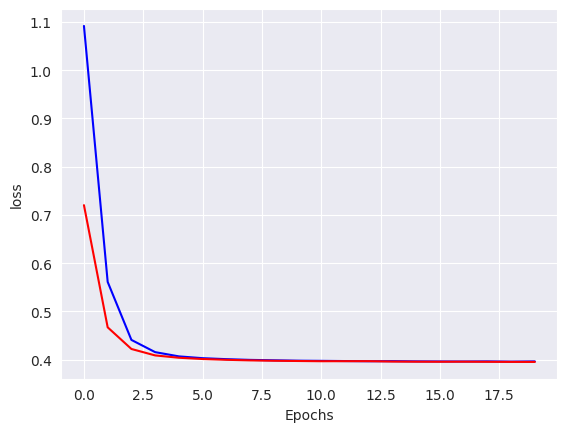

In [49]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss fuction

plt.plot(history.history["loss"], color='b')
plt.plot(history.history["val_loss"], color='r')
plt.ylabel("loss")
plt.xlabel('Epochs')
plt.show()

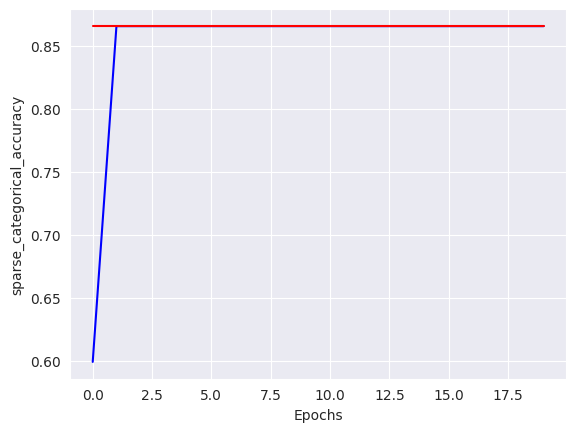

In [50]:
# Visualization of accuracy training
plt.plot(history.history["sparse_categorical_accuracy"], color="b")
plt.plot(history.history["val_sparse_categorical_accuracy"], color="r")
plt.ylabel("sparse_categorical_accuracy")
plt.xlabel("Epochs")
plt.show()

### GRU

Create an object named model_gru by replacing the SimpleRNN layers by GRU layers and replicate the same steps.


In [51]:
embedding_dim=64 # the dimensionality of the representation space
vocab_size = len(tokenizer.word_index)

model_gru = Sequential([
  # Word embadding layer
  Embedding(vocab_size+1, embedding_dim,input_shape=[message_pad.shape[1],], name="embedding"), # the embedding layer
  # the input dim needs to be equal to the size of the vocabulary + 1 (because of
  # the zero padding)
  GRU(units=64, return_sequences=True), # maintains the sequential nature
  GRU(units=32, return_sequences=False), # returns the last output
  Dense(16, activation='relu'), # a dense layer
  Dense(8, activation="relu"), # the prediction layer
  Dense(5, activation="softmax")
])

In [52]:
model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 74, 64)            524928    
                                                                 
 gru (GRU)                   (None, 74, 64)            24960     
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 5)                 45        
                                                                 
Total params: 560,005
Trainable params: 560,005
Non-tr

In [53]:
# Install and import tensorflow-addons to use f1-score as an evaluation metric in training

# !pip install tensorflow-addons -q
# import tensorflow_addons as tfa

optimizer= tf.keras.optimizers.Adam()

model_gru.compile(optimizer=optimizer,
                  # loss=tf.keras.losses.BinaryCrossentropy(),
              # metrics=['accuracy',tfa.metrics.F1Score(num_classes = 1, average = 'micro', threshold = 0.5)])
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [54]:
# Model training
history = model_gru.fit(train_batch, validation_data=val_batch, epochs=20)

Epoch 1/20
61/61 [==============================] - 15s 134ms/step - loss: 1.4838 - sparse_categorical_accuracy: 0.0000e+00 - val_loss: 1.3806 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/20
61/61 [==============================] - 7s 118ms/step - loss: 1.2574 - sparse_categorical_accuracy: 0.0252 - val_loss: 1.1020 - val_sparse_categorical_accuracy: 0.8656
Epoch 3/20
61/61 [==============================] - 8s 127ms/step - loss: 0.8218 - sparse_categorical_accuracy: 0.8654 - val_loss: 0.5100 - val_sparse_categorical_accuracy: 0.8656
Epoch 4/20
61/61 [==============================] - 7s 123ms/step - loss: 0.4358 - sparse_categorical_accuracy: 0.8654 - val_loss: 0.4030 - val_sparse_categorical_accuracy: 0.8656
Epoch 5/20
61/61 [==============================] - 7s 110ms/step - loss: 0.4001 - sparse_categorical_accuracy: 0.8654 - val_loss: 0.3976 - val_sparse_categorical_accuracy: 0.8656
Epoch 6/20
61/61 [==============================] - 8s 126ms/step - loss: 0.3975 - sparse_c

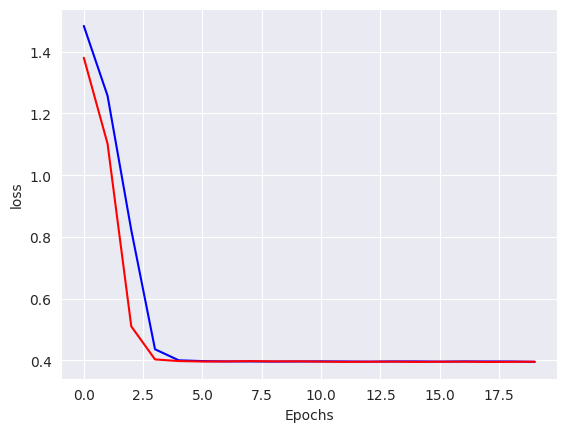

In [55]:
# Visualization of the training process on the loss fuction

plt.plot(history.history["loss"], color='b')
plt.plot(history.history["val_loss"], color='r')
plt.ylabel("loss")
plt.xlabel('Epochs')
plt.show()

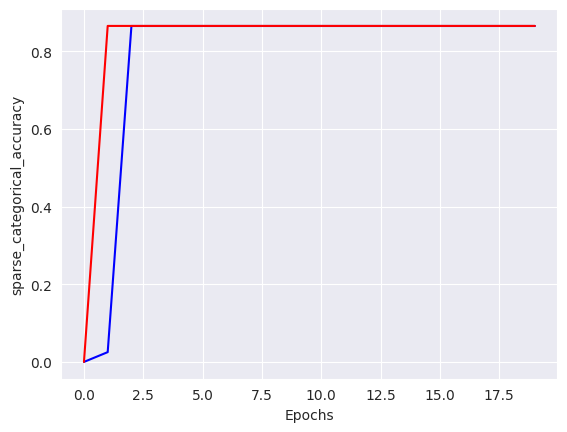

In [56]:
# Visualization of accuracy training
plt.plot(history.history["sparse_categorical_accuracy"], color="b")
plt.plot(history.history["val_sparse_categorical_accuracy"], color="r")
plt.ylabel("sparse_categorical_accuracy")
plt.xlabel("Epochs")
plt.show()

### LSTM

Create an object named model_lstm by replacing the SimpleRNN layers by LSTM layers and replicate the same steps.


In [57]:
embedding_dim=message_pad.shape[0] # the dimensionality of the representation space
vocab_size = len(tokenizer.word_index)

model_lstm = Sequential([
  # Word embadding layer
  Embedding(vocab_size+1, embedding_dim,input_shape=[message_pad.shape[1],], name="embedding"), # the embedding layer
  # the input dim needs to be equal to the size of the vocabulary + 1 (because of
  # the zero padding)
  LSTM(units=64, return_sequences=True), # maintains the sequential nature
  LSTM(units=32, return_sequences=False), # returns the last output
  Dense(16, activation='relu'), # a dense layer
  Dense(8, activation="relu"), # the prediction layer
  Dense(5, activation="softmax")
])

In [58]:
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 74, 5554)          45553908  
                                                                 
 lstm (LSTM)                 (None, 74, 64)            1438464   
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 8)                 136       
                                                                 
 dense_8 (Dense)             (None, 5)                 45        
                                                                 
Total params: 47,005,497
Trainable params: 47,005,497


In [59]:
optimizer= tf.keras.optimizers.Adam()

model_lstm.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [60]:
# Model training
history = model_lstm.fit(train_batch,
          epochs=20,
          validation_data=val_batch)

Epoch 1/20
61/61 [==============================] - 168s 3s/step - loss: 0.9356 - sparse_categorical_accuracy: 0.8510 - val_loss: 0.7682 - val_sparse_categorical_accuracy: 0.8656
Epoch 2/20
61/61 [==============================] - 161s 3s/step - loss: 0.7087 - sparse_categorical_accuracy: 0.8654 - val_loss: 0.6136 - val_sparse_categorical_accuracy: 0.8656
Epoch 3/20
61/61 [==============================] - 161s 3s/step - loss: 0.4942 - sparse_categorical_accuracy: 0.8654 - val_loss: 0.4276 - val_sparse_categorical_accuracy: 0.8656
Epoch 4/20
61/61 [==============================] - 160s 3s/step - loss: 0.4099 - sparse_categorical_accuracy: 0.8654 - val_loss: 0.4009 - val_sparse_categorical_accuracy: 0.8656
Epoch 5/20
61/61 [==============================] - 155s 3s/step - loss: 0.3999 - sparse_categorical_accuracy: 0.8654 - val_loss: 0.4014 - val_sparse_categorical_accuracy: 0.8656
Epoch 6/20
61/61 [==============================] - 192s 3s/step - loss: 0.3994 - sparse_categorical_accu

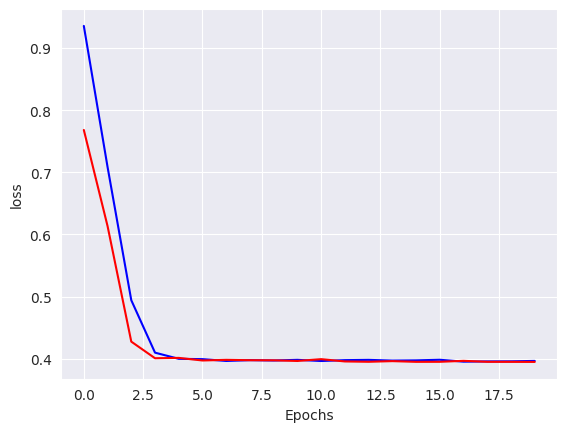

In [61]:
plt.plot(history.history["loss"], color='b')
plt.plot(history.history["val_loss"], color='r')
plt.ylabel("loss")
plt.xlabel('Epochs')
plt.show()

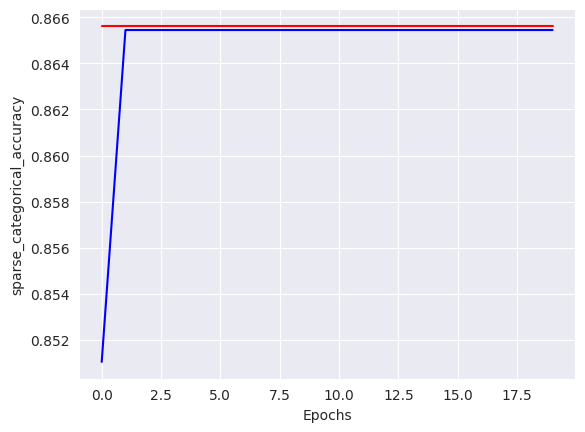

In [62]:
# Visualization of accuracy training
plt.plot(history.history["sparse_categorical_accuracy"], color="b")
plt.plot(history.history["val_sparse_categorical_accuracy"], color="r")
plt.ylabel("sparse_categorical_accuracy")
plt.xlabel("Epochs")
plt.show()

### Model choice

We see that of the three recurrent model architectures we tried, the LSTM one performs better, and starts overfitting after epoch 15

**=> We'll choose to use the LSTM architecture trained on 15 epochs.**


In [63]:
# Starting over the training of the choosed model on less epochs
optimizer= tf.keras.optimizers.Adam()
model = tf.keras.models.clone_model(model_lstm)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
# Model training
history = model.fit(train_batch,
          epochs=15,
          validation_data=val_batch)

Epoch 1/15
61/61 [==============================] - 163s 3s/step - loss: 0.7203 - sparse_categorical_accuracy: 0.8513 - val_loss: 0.4256 - val_sparse_categorical_accuracy: 0.8656
Epoch 2/15
61/61 [==============================] - 165s 3s/step - loss: 0.4132 - sparse_categorical_accuracy: 0.8654 - val_loss: 0.4033 - val_sparse_categorical_accuracy: 0.8656
Epoch 3/15
61/61 [==============================] - 172s 3s/step - loss: 0.4013 - sparse_categorical_accuracy: 0.8654 - val_loss: 0.3984 - val_sparse_categorical_accuracy: 0.8656
Epoch 4/15
61/61 [==============================] - 164s 3s/step - loss: 0.3988 - sparse_categorical_accuracy: 0.8654 - val_loss: 0.3976 - val_sparse_categorical_accuracy: 0.8656
Epoch 5/15
61/61 [==============================] - 162s 3s/step - loss: 0.3975 - sparse_categorical_accuracy: 0.8654 - val_loss: 0.4004 - val_sparse_categorical_accuracy: 0.8656
Epoch 6/15
61/61 [==============================] - 154s 3s/step - loss: 0.3983 - sparse_categorical_accu

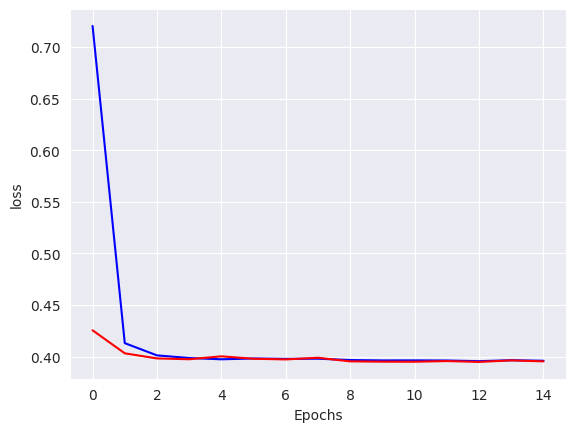

In [64]:
plt.plot(history.history["loss"], color='b')
plt.plot(history.history["val_loss"], color='r')
plt.ylabel("loss")
plt.xlabel('Epochs')
plt.show()

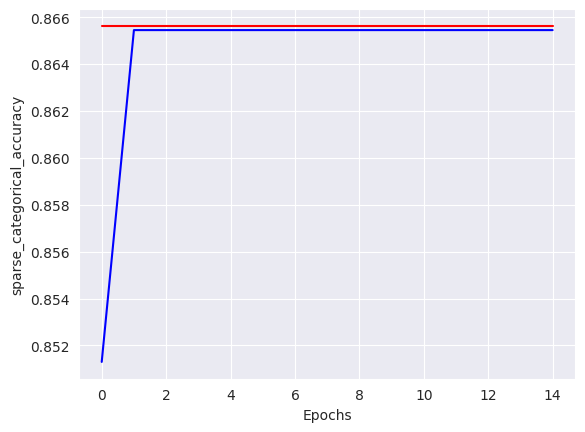

In [65]:
# Visualization of accuracy training
plt.plot(history.history["sparse_categorical_accuracy"], color="b")
plt.plot(history.history["val_sparse_categorical_accuracy"], color="r")
plt.ylabel("sparse_categorical_accuracy")
plt.xlabel("Epochs")
plt.show()